# Egg Production - Regression task

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Egg_Production.csv')
df

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise,Total_egg_production
0,2728,170,14.4,29.3,51.7,364,214,2115
1,2728,175,17.6,29.3,52.3,369,235,1958
2,2728,175,15.0,29.3,52.5,373,237,1990
3,2728,170,15.0,29.3,49.7,372,240,2015
4,2728,170,15.9,29.2,51.4,381,237,2112
...,...,...,...,...,...,...,...,...
476,2735,180,14.4,29.0,49.5,341,224,2065
477,2735,185,14.9,29.5,50.7,317,202,2202
478,2735,180,16.0,29.5,49.3,346,197,1972
479,2732,195,13.4,30.0,51.7,325,183,2120


In [4]:
df = df.drop_duplicates()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Amount_of_chicken     74 non-null     int64  
 1   Amount_of_Feeding     74 non-null     int64  
 2   Ammonia               74 non-null     float64
 3   Temperature           74 non-null     float64
 4   Humidity              74 non-null     float64
 5   Light_Intensity       74 non-null     int64  
 6   Noise                 74 non-null     int64  
 7   Total_egg_production  74 non-null     int64  
dtypes: float64(3), int64(5)
memory usage: 5.2 KB


### Exploratory Data Analysis

In [6]:
df.describe()

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise,Total_egg_production
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,2712.513514,181.148649,15.054054,29.614865,50.966216,332.716216,199.540541,1955.905405
std,35.798616,8.298675,1.128727,0.775248,1.715783,30.614045,38.851029,177.435705
min,2639.000000,170.000000,13.100000,28.500000,46.100000,239.000000,81.000000,1479.000000
25%,2721.000000,175.000000,14.200000,29.100000,49.925000,318.000000,195.500000,1825.750000
50%,2728.000000,180.000000,15.000000,29.250000,50.900000,336.000000,209.500000,2015.000000
75%,2735.000000,190.000000,15.875000,30.000000,52.050000,351.000000,218.000000,2065.000000
max,2745.000000,200.000000,17.900000,32.000000,54.300000,381.000000,241.000000,2271.000000


The mean amount of chicken in the poultry are 2710. In average, they eat 182kg of foods. 
The mean temperature of the poultry is about 29°C.

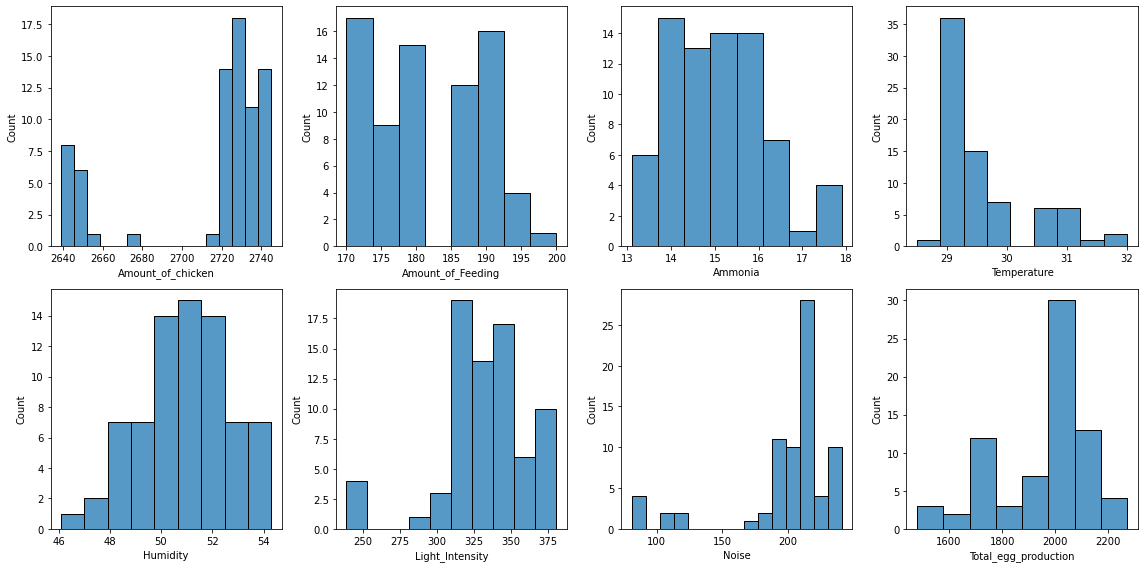

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.flatten()

for i, c in enumerate(df.columns):
    sns.histplot(df[c], ax=ax[i])

plt.tight_layout()
plt.show()

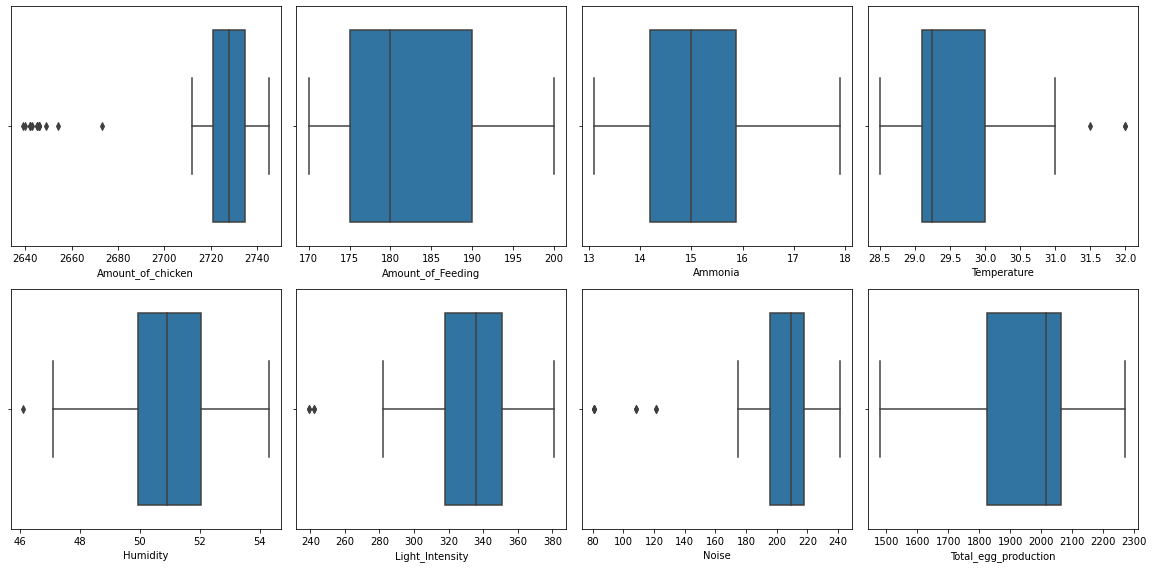

In [8]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.flatten()

for i, c in enumerate(df.columns):
    sns.boxplot(x=df[c], ax=ax[i])

plt.tight_layout()
plt.show()

<AxesSubplot:>

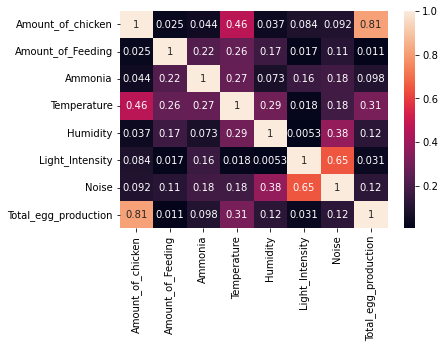

In [9]:
sns.heatmap(abs(df.corr()),annot=True)

It shows that the toal egg prediction is mostly affected by the amount of chicken. The other value points in the correlation table shows the relationship between variables

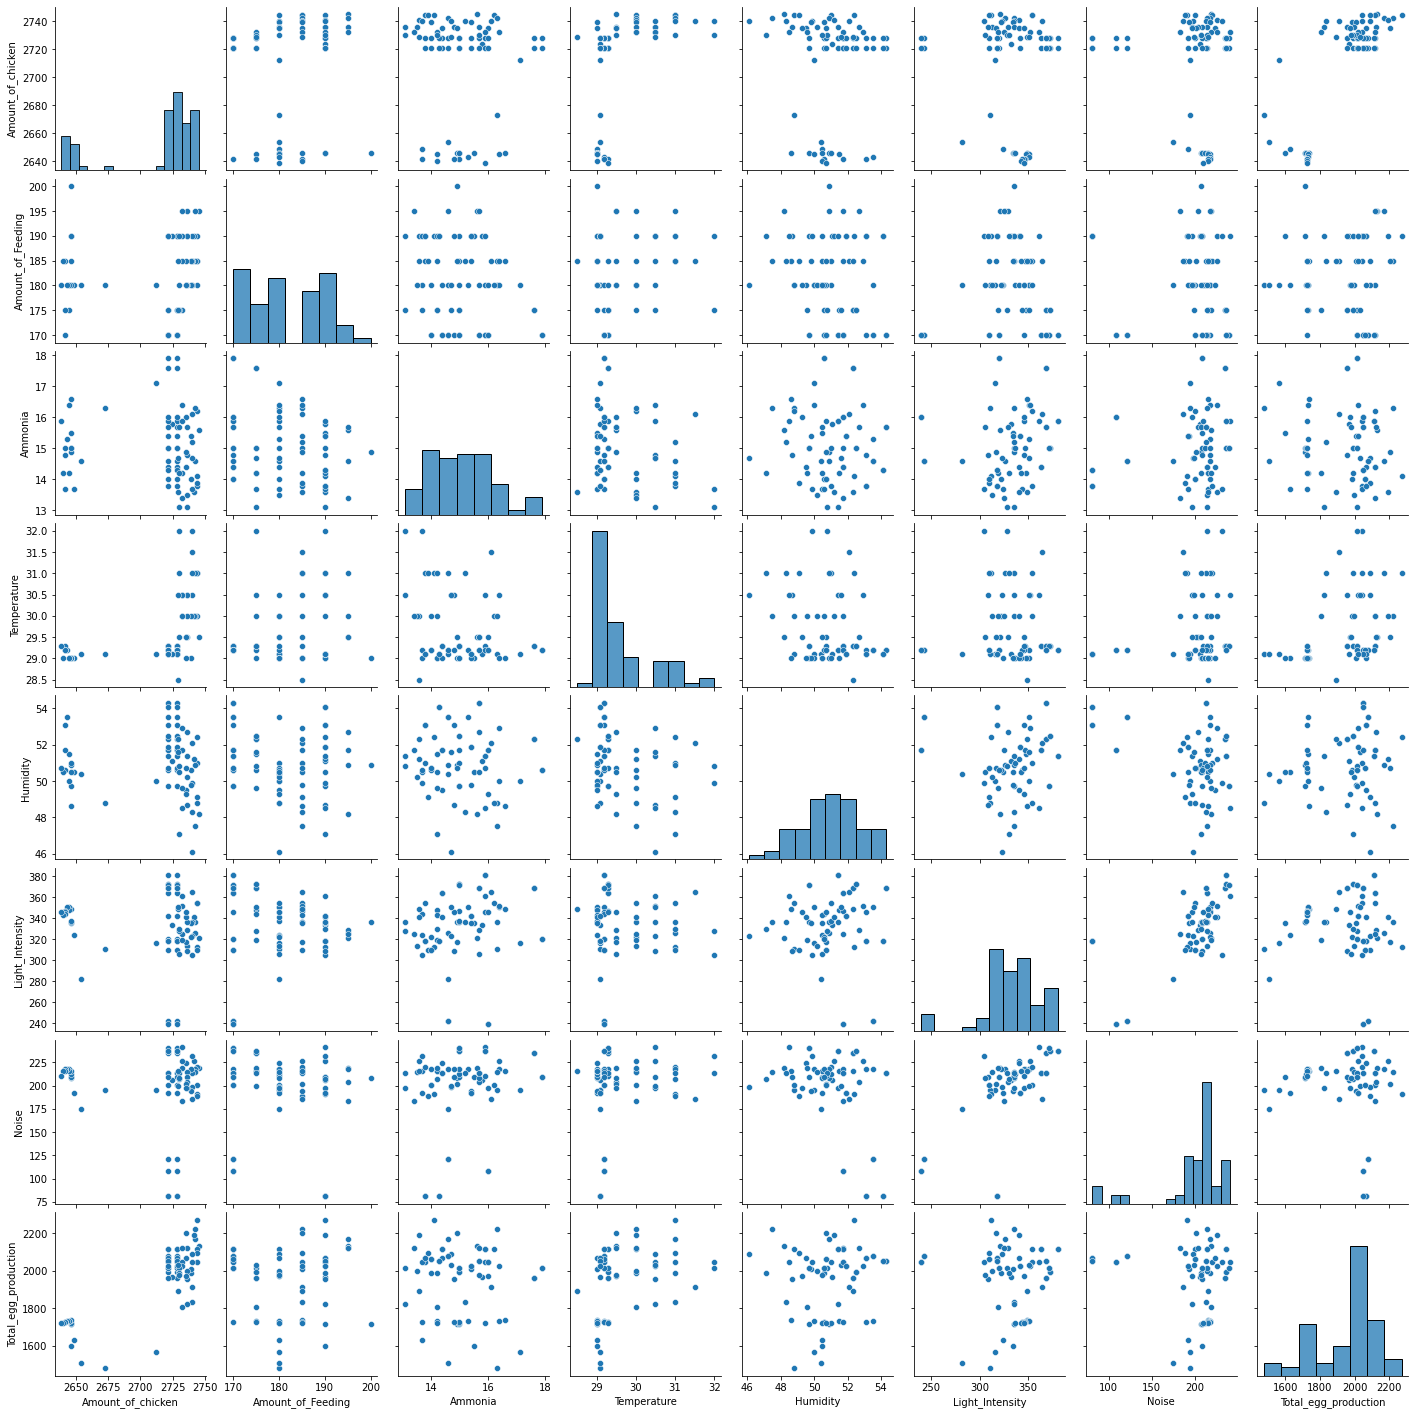

In [10]:
sns.pairplot(data=df)

# Model building

For the Machine Learning model building, let us use the following features to predict the total egg production :
- Amount of Chicken
- Temperature
- Light Intensity
- Noise

The numbers of records are small so using a complex model will lead us to overfitting the training set. So, we are going to choose, simple linear model called "Ridge Regression" and Scale the input data with RobustScaler method so that it will not be affected by any outliers values.

The data transformations and the model is inside a Scikit-Learn pipeline to avoid data leakage. 

In [11]:
#df_ = df.drop_duplicates().copy()
X = df[['Amount_of_chicken','Temperature','Light_Intensity','Noise']]
y = df['Total_egg_production']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.compose import make_column_transformer
from sklearn.ensemble import IsolationForest

From the Exploratory Data Analysis, we have seen that the data has some outliers. Outliers affect the models performance so it is better to remove them.

In [13]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,random_state=100,test_size=0.2)
preproc = make_pipeline(MinMaxScaler())
isf = make_pipeline(preproc,IsolationForest(contamination=0.07))
isf.fit(X_train)
idx_data = isf.predict(X_train)==1
Y_train = Y_train[idx_data]
X_train = X_train[idx_data]

In [20]:
ridge = make_pipeline(preproc,Ridge(random_state=100))

In [21]:
ridge.fit(X_train,Y_train)
ridge.score(X_test,Y_test)

0.6770071642799613

In [15]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,make_scorer

def plot_learning_curves(model):
    (N,train_score,val_score) = learning_curve(model,X_train,Y_train,cv=5)
    train_score = train_score.mean(axis=1)
    val_score = val_score.mean(axis=1)
    plt.plot(N,train_score,label='train_score',color='orange')
    plt.plot(N,val_score,label='val_score',color='blue')
    #plt.tight_layout()
    plt.title("Learning curves")
    plt.xlabel("Training data size")
    plt.ylabel("Score")
    plt.legend()
    print('Validation score: ', val_score[-1])

Validation score:  0.5654804137474808


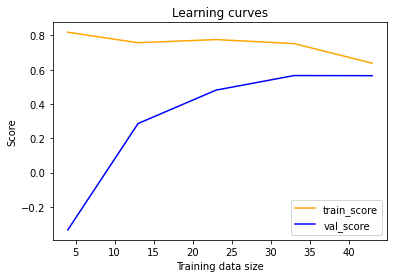

In [16]:
plot_learning_curves(ridge)

As the number of training records grows, the R2 score on the train set decrease. On the other side, the R2 score from the validation data increase. This is an indicative that our model does not suffer from overfitting.

In [17]:
ridge.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
  ('ridge', Ridge())],
 'verbose': False,
 'pipeline': Pipeline(steps=[('minmaxscaler', MinMaxScaler())]),
 'ridge': Ridge(),
 'pipeline__memory': None,
 'pipeline__steps': [('minmaxscaler', MinMaxScaler())],
 'pipeline__verbose': False,
 'pipeline__minmaxscaler': MinMaxScaler(),
 'pipeline__minmaxscaler__clip': False,
 'pipeline__minmaxscaler__copy': True,
 'pipeline__minmaxscaler__feature_range': (0, 1),
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

## Hyperparameters Optimization
We are going to use a GridSearch algorithm to find the coefficient "alpha" that maximize the crossvalidation score of the model.

Validation score:  0.5909235760092006


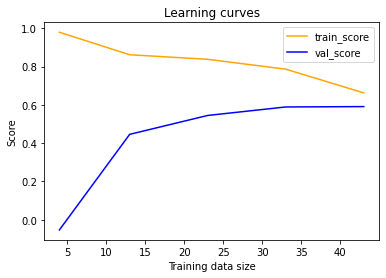

In [18]:
from sklearn.model_selection import GridSearchCV
grid = {
    'ridge__alpha':[0.0005,0.001,0.01,0.05,0.1,0.2]
}
gs = GridSearchCV(estimator=ridge,param_grid=grid,scoring='r2',n_jobs=4)
gs.fit(X_train,Y_train)
ridge = gs.best_estimator_
plot_learning_curves(ridge)

In [19]:
ridge.score(X_test,Y_test)

0.681380866872703

# Conclusion

From the dataset that we have, we performed a Ridge Regression able to predict total egg production with a R2 score 67% on new data. With the amount of data we have in hands, that performance can be appreciated and the module will certainly improve if we can collect more quality dataset and the use a more complex algorithms such as Random Forest Regressor or Support Vector Regressor.

# Export the model into a file

In [20]:
import joblib
joblib.dump(ridge,)